# Computer Visual Individual



## Set UP

### Imports

In [1]:
import tensorflow as tf
from tensorflow import keras
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator

from matplotlib import pyplot as plt
%matplotlib inline

import os
import numpy as np
from sklearn.metrics import confusion_matrix

print('Keras version:',keras.__version__)

Keras version: 2.12.0


In [2]:
# Create dic that will hold the model name and the model, to be used to comapre the performance of the models
trained_models = {}

### Data Imports

Images imported at 128x128, a smaller size than the origiginals, this decision was taken to reduce training time due to the extemly good results yielded by the models.

Might be interesting to further lower the size to 64

In [3]:

# Getting the image from local repo
training_folder_name = 'state-farm-distracted-driver-detection/imgs/train'

# The folder contains a subfolder for each class of shape
classes = sorted(os.listdir(training_folder_name))
print(classes)

# Choose img size 128 to make the trainging faster given that the models perform extremly well,
#  might be interresting to further reduce the size of the images
pretrained_size = (128,128)
batch_size = 15

print("Getting Data...")
datagen = ImageDataGenerator(rescale=1./255, # normalize pixel values
                             validation_split=0.3) # hold back 30% of the images for validation

print("Preparing training dataset...")
train_generator = datagen.flow_from_directory(
    training_folder_name,
    target_size=pretrained_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # set as training data

print("Preparing validation dataset...")
validation_generator = datagen.flow_from_directory(
    training_folder_name,
    target_size=pretrained_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # set as validation data

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']
Getting Data...
Preparing training dataset...


Found 15702 images belonging to 10 classes.
Preparing validation dataset...
Found 6722 images belonging to 10 classes.


#### Show sample of images we are working on

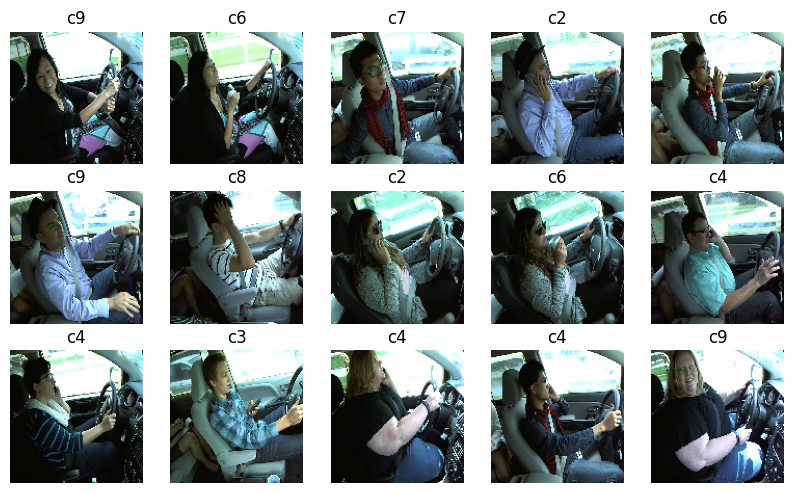

In [4]:
# Get the classes
classes = list(train_generator.class_indices.keys())

# Get one batch of images and labels
images, labels = next(train_generator)


# Show some of the images
plt.figure(figsize=(10,10))
for i in range(15):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i])
    plt.title(classes[np.argmax(labels[i])])
    plt.axis("off")

plt.show()

### Helper Functions

In [5]:

def get_confusion_matrix(model):
    print("Generating predictions from validation data...")
    # Get the image and label arrays for the first batch of validation data
    x_test = validation_generator[0][0]
    y_test = validation_generator[0][1]

    # Use the moedl to predict the class
    class_probabilities = model.predict(x_test)

    # The model returns a probability value for each class
    # The one with the highest probability is the predicted class
    predictions = np.argmax(class_probabilities, axis=1)

    # The actual labels are hot encoded (e.g. [0 1 0], so get the one with the value 1
    true_labels = np.argmax(y_test, axis=1)

    # Plot the confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=85)
    plt.yticks(tick_marks, classes)
    plt.xlabel("Predicted Class")
    plt.ylabel("True Class")
    plt.show()

## Transfer Learning

Initially Istarted by testing transfer learning. I began by employing VGG16,while it yielded very good accuracy and low loss, it was quite time-consuming.

To address this, I decided to experiment with the ligher model MobileNet. 

During my experimentation with both VGG16 and MobileNet, I found that adjusting the learning rate for the optimizer did not improve the accuracy but highly increased the loss (see MobileNet, learning rate 0.01), even by increasing the number of epoch the loss did not decreased significantly.

I also tried using mobileNetV1 vs V2 vs v3 small and v3 Large to compare the performance of the two models:
- V3 Small  = loss: 0.7451 - accuracy: 0.7528 - val_loss: 0.3970 - val_accuracy: 0.8807
- V3 Large = loss: 0.2931 - accuracy: 0.9088 - val_loss: 0.2286 - val_accuracy: 0.9330 (2 epoch)

Since V1 and V2 delivered the best performance in the same amount of time I am going to include only them

### Mobile Net V1 lr 0.001 with Batch Normalization

Batch normalization is a technique for improving the speed, performance, and stability of artificial neural networks.
Batch normalization normalizes the output of a previous activation layer by subtracting the batch mean and dividing
by the batch standard deviation. However, these operations could change what the layer can represent, 
so the technique also introduces two learnable parameters (multiplied and added) that can undo the normalization. 
This allows the network to decide the optimal scale and mean of the activations.

In [6]:
from keras.applications.mobilenet import MobileNet
from keras.layers import Flatten, Dense, BatchNormalization
from keras.models import Model
from keras import optimizers

In [7]:
# Load the MobileNet model, excluding its final connected layer, and set the input shape to match our images
Mobile_net_base_model = MobileNet(weights='imagenet', include_top=False, input_shape=train_generator.image_shape)

# Freeze the already-trained layers in the base model
for layer in Mobile_net_base_model.layers:
    layer.trainable = False

# Create layers for classification of our images
x = Mobile_net_base_model.output
x = Flatten()(x)
x = BatchNormalization()(x)  # Added BatchNormalization layer
prediction_layer = Dense(len(classes), activation='softmax')(x)
Mobile_net_model_001 = Model(inputs=Mobile_net_base_model.input, outputs=prediction_layer)

# Compile the model
opt = optimizers.Adam(lr=0.001)
Mobile_net_model_001.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# Now print the full model, which will include the layers of the base model plus the dense layer and BatchNormalization layer we added
print(Mobile_net_model_001.summary())


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 64, 64, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 64, 64, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 64, 64, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 64, 64, 32)       128       
 ation)                                                      

c:\Users\lucac\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


 ation)                                                          
                                                                 
 conv_dw_5_relu (ReLU)       (None, 16, 16, 256)       0         
                                                                 
 conv_pw_5 (Conv2D)          (None, 16, 16, 256)       65536     
                                                                 
 conv_pw_5_bn (BatchNormaliz  (None, 16, 16, 256)      1024      
 ation)                                                          
                                                                 
 conv_pw_5_relu (ReLU)       (None, 16, 16, 256)       0         
                                                                 
 conv_pad_6 (ZeroPadding2D)  (None, 17, 17, 256)       0         
                                                                 
 conv_dw_6 (DepthwiseConv2D)  (None, 8, 8, 256)        2304      
                                                                 
 conv_dw_6

In [9]:
# Train the model over 1 epoch using 15-image batches and using the validation holdout dataset for validation
num_epochs = 1
Mobile_net_model_001_history = Mobile_net_model_001.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // batch_size,
    epochs = num_epochs)
Mobile_net_model_001.save('/Models/Models_repo/Mobile_net_model_001.h5')
trained_models["Mobile_net_model_001"] = Mobile_net_model_001

1046/1046 [==============================] - 148s 141ms/step - loss: 0.0626 - accuracy: 0.9847 - val_loss: 0.1164 - val_accuracy: 0.9817


Generating predictions from validation data...
1/1 [==============================] - 1s 986ms/step


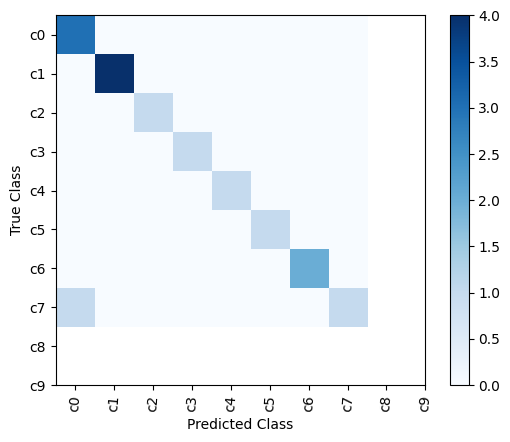

In [10]:
get_confusion_matrix(Mobile_net_model_001)

### Mobile Net V2 lr 0.001 with Batch Normalization

In [11]:
from keras.applications import MobileNetV2
from keras.layers import Flatten, Dense, BatchNormalization
from keras.models import Model
from keras import optimizers

In [13]:
# Load the MobileNet model, excluding its final connected layer, and set the input shape to match our images
Mobile_net_v2_base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=train_generator.image_shape)

# Freeze the already-trained layers in the base model
for layer in Mobile_net_v2_base_model.layers:
    layer.trainable = False

# Create layers for classification of our images
x = Mobile_net_v2_base_model.output
x = Flatten()(x)
x = BatchNormalization()(x)  # Added BatchNormalization layer
prediction_layer = Dense(len(classes), activation='softmax')(x)
Mobile_net_v2_model_001 = Model(inputs=Mobile_net_v2_base_model.input, outputs=prediction_layer)

# Compile the model
opt = optimizers.Adam(lr=0.001)
Mobile_net_v2_model_001.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# Now print the full model, which will include the layers of the base model plus the dense layer and BatchNormalization layer we added
print(Mobile_net_v2_model_001.summary())


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_3[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][0]']         

In [14]:
# Train the model over 1 epoch using 15-image batches and using the validation holdout dataset for validation
num_epochs = 1
Mobile_net_v2_model_001_history = Mobile_net_v2_model_001.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // batch_size,
    epochs = num_epochs)
Mobile_net_v2_model_001.save('/Models/Models_repo/Mobile_net_v2_model_001.h5')
trained_models["Mobile_net_v2_model_001"] = Mobile_net_v2_model_001

1046/1046 [==============================] - 184s 170ms/step - loss: 0.4633 - accuracy: 0.8990 - val_loss: 0.1557 - val_accuracy: 0.9734


Generating predictions from validation data...
1/1 [==============================] - 3s 3s/step


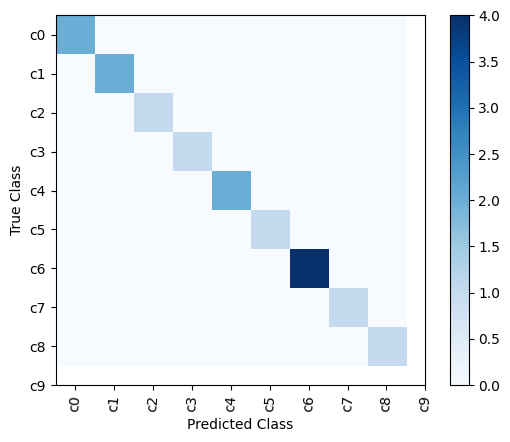

In [15]:
get_confusion_matrix(Mobile_net_v2_model_001)

### Mobile Net V1 lr 0.01

In [16]:
# Load the MobileNet model, excluding its final connected layer, and set the input shape to match our images
Mobile_net_base_model = MobileNet(weights='imagenet', include_top=False, input_shape=train_generator.image_shape)

# Freeze the already-trained layers in the base model
for layer in Mobile_net_base_model.layers:
    layer.trainable = False

# Create layers for classification of our images
x = Mobile_net_base_model.output
x = Flatten()(x)
prediction_layer = Dense(len(classes), activation='softmax')(x)
Mobile_net_model_01 = Model(inputs=Mobile_net_base_model.input, outputs=prediction_layer)

# Compile the model
opt = optimizers.Adam(lr=0.01)
Mobile_net_model_01.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# Now print the full model, which will include the layers of the base model plus the dense layer and BatchNormalization layer we added
print(Mobile_net_model_01.summary())


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 64, 64, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 64, 64, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 64, 64, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 64, 64, 32)       128       
 ation)                                                    

c:\Users\lucac\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


 conv_dw_7 (DepthwiseConv2D)  (None, 8, 8, 512)        4608      
                                                                 
 conv_dw_7_bn (BatchNormaliz  (None, 8, 8, 512)        2048      
 ation)                                                          
                                                                 
 conv_dw_7_relu (ReLU)       (None, 8, 8, 512)         0         
                                                                 
 conv_pw_7 (Conv2D)          (None, 8, 8, 512)         262144    
                                                                 
 conv_pw_7_bn (BatchNormaliz  (None, 8, 8, 512)        2048      
 ation)                                                          
                                                                 
 conv_pw_7_relu (ReLU)       (None, 8, 8, 512)         0         
                                                                 
 conv_dw_8 (DepthwiseConv2D)  (None, 8, 8, 512)        4608      
          

In [17]:
# Train the model over 1 epoch using 15-image batches and using the validation holdout dataset for validation
num_epochs = 3
Mobile_net_model_01_history = Mobile_net_model_01.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // batch_size,
    epochs = num_epochs)
Mobile_net_model_01.save('/Models/Models_repo/Mobile_net_model_01.h5')
trained_models["Mobile_net_model_01"] = Mobile_net_model_01

1046/1046 [==============================] - 149s 139ms/step - loss: 5.3855 - accuracy: 0.8902 - val_loss: 3.3050 - val_accuracy: 0.9418
Epoch 2/3
1046/1046 [==============================] - 142s 135ms/step - loss: 1.8570 - accuracy: 0.9700 - val_loss: 1.6679 - val_accuracy: 0.9729
Epoch 3/3
1046/1046 [==============================] - 141s 135ms/step - loss: 1.5196 - accuracy: 0.9775 - val_loss: 2.5122 - val_accuracy: 0.9734


Generating predictions from validation data...


1/1 [==============================] - 1s 1s/step


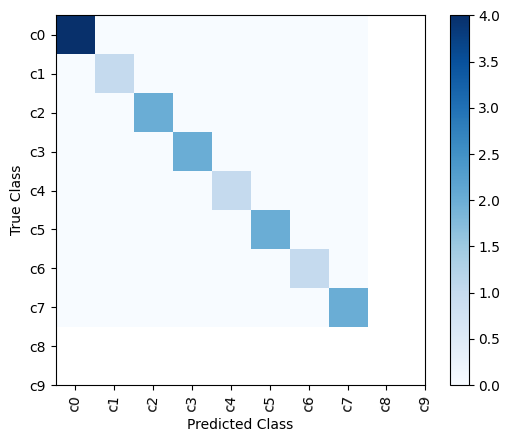

In [18]:
get_confusion_matrix(Mobile_net_model_01)

### VGG16 Imaget Model

In [20]:
from keras.applications.vgg16 import VGG16
#Load the base model, not including its final connected layer, and set the input shape to match our images
vgg16_base_model = VGG16(weights='imagenet', include_top=False, input_shape=train_generator.image_shape)

In [21]:
from keras import Model
from keras.layers import Flatten, Dense
from keras import optimizers

# Freeze the already-trained layers in the base model
for layer in vgg16_base_model.layers:
    layer.trainable = False

# Create layers for classification of our images
x = vgg16_base_model.output
x = Flatten()(x)
prediction_layer = Dense(len(classes), activation='softmax')(x)
vgg16_model = Model(inputs=vgg16_base_model.input, outputs=prediction_layer)

# Compile the model
opt = optimizers.Adam(lr=0.001)
vgg16_model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

# Now print the full model, which will include the layers of the base model plus the dense layer we added
print(vgg16_model.summary())

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

c:\Users\lucac\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [22]:
# Train the model over 1 epoch using 15-image batches and using the validation holdout dataset for validation
num_epochs = 1
vgg16_history = vgg16_model.fit_generator(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // batch_size,
    epochs = num_epochs)
vgg16_model.save('/Models/Models_repo/Imaget_VGG16.h5')
trained_models["vgg16_model"] = vgg16_model


1046/1046 [==============================] - 745s 711ms/step - loss: 0.3906 - accuracy: 0.8996 - val_loss: 0.1341 - val_accuracy: 0.9696


Generating predictions from validation data...
1/1 [==============================] - 1s 823ms/step


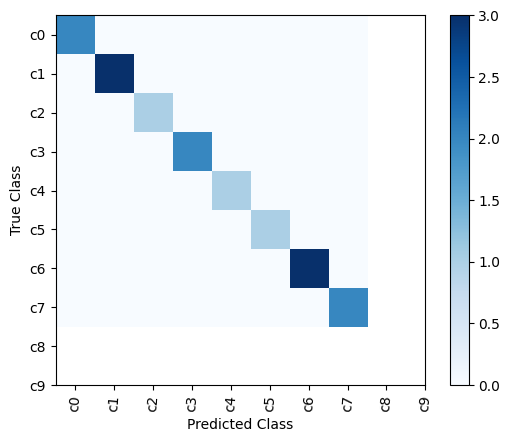

In [23]:
get_confusion_matrix(vgg16_model)

## CNN Models

As per the transfer learning models, I fist used a "default" CNN (Conv2D, MaxPooling2D, Conv2D,MaxPooling2D, Flatten, Dense, optimizer), but while testing I noticed that the second Conv2D,MaxPooling2D laers where not helping the model in a significant way for both accuracy and loss. So I decided to remove them.

In addition I also tried to experiement with the leanring rate of the optimizer, with values ( 0.01, 0.005 and some in between) but all cripled the model performance, in both accuracy and loss. Also adding more epoch did not help, but just increased learning time

### CNN lr = 0.001

In [24]:
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Flatten, Dense
from keras import optimizers
import tensorflow as tf

In [25]:
# Define the model as a sequence of layers
CNNmodel_001 = Sequential()

# The input layer accepts an image and applies a convolution that uses 32 6x6 filters and a rectified linear unit activation function
CNNmodel_001.add(Conv2D(32, (6, 6), input_shape=train_generator.image_shape, activation='relu'))

# Next we'll add a max pooling layer with a 2x2 patch
CNNmodel_001.add(MaxPooling2D(pool_size=(2,2)))

# Removed a convolution layer and a max poolinglayer since they were not helpful
#model.add(Conv2D(32, (6, 6), activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))

# Now we'll flatten the feature maps and generate an output layer with a predicted probability for each class
CNNmodel_001.add(Flatten())
CNNmodel_001.add(Dense(train_generator.num_classes, activation='softmax'))

# We'll use the ADAM optimizer
#other optimizers can also be used for example SGD stochastic gradient descent
opt = tf.optimizers.Adam(learning_rate=0.001)

# With the layers defined, we can now compile the model for categorical (multi-class) classification
CNNmodel_001.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

print(CNNmodel_001.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 123, 123, 32)      3488      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 61, 61, 32)       0         
 )                                                               
                                                                 
 flatten_5 (Flatten)         (None, 119072)            0         
                                                                 
 dense_5 (Dense)             (None, 10)                1190730   
                                                                 
Total params: 1,194,218
Trainable params: 1,194,218
Non-trainable params: 0
_________________________________________________________________
None


In [26]:
num_epochs = 1
CNN_history_001 = CNNmodel_001.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // batch_size,
    epochs = num_epochs)

CNNmodel_001.save('/Models/Models_repo/CNNmodel_001.h5')
trained_models["CNNmodel_001"] = CNNmodel_001

1046/1046 [==============================] - 182s 172ms/step - loss: 0.3936 - accuracy: 0.8819 - val_loss: 0.0767 - val_accuracy: 0.9805


Generating predictions from validation data...
1/1 [==============================] - 0s 126ms/step


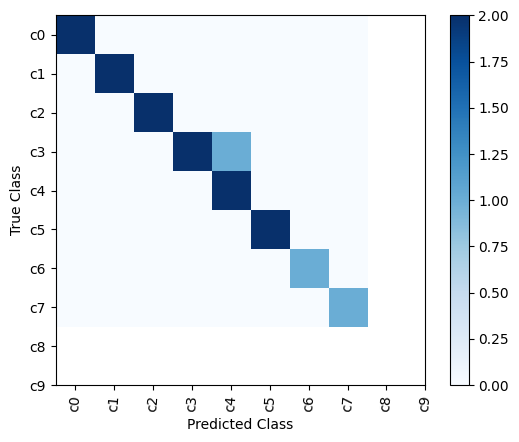

In [27]:
get_confusion_matrix(CNNmodel_001)

### CNN lr = 0.005

Since the CNN model has high accurazy and low loss, I am goign to try to reduce the alpha and see how it impacts

In [28]:
# Define the model as a sequence of layers
CNNmodel_a_005 = Sequential()

# The input layer accepts an image and applies a convolution that uses 32 6x6 filters and a rectified linear unit activation function
CNNmodel_a_005.add(Conv2D(32, (6, 6), input_shape=train_generator.image_shape, activation='relu'))

# Next we'll add a max pooling layer with a 2x2 patch
CNNmodel_a_005.add(MaxPooling2D(pool_size=(2,2)))

# Removed a convolution layer and a max poolinglayer since they were not helpful
CNNmodel_a_005.add(Conv2D(32, (6, 6), activation='relu'))
CNNmodel_a_005.add(MaxPooling2D(pool_size=(2, 2)))

# Now we'll flatten the feature maps and generate an output layer with a predicted probability for each class
CNNmodel_a_005.add(Flatten())
CNNmodel_a_005.add(Dense(train_generator.num_classes, activation='softmax'))

# We'll use the ADAM optimizer
#other optimizers can also be used for example SGD stochastic gradient descent
opt = tf.optimizers.Adam(learning_rate=0.005)

# With the layers defined, we can now compile the model for categorical (multi-class) classification
CNNmodel_a_005.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

print(CNNmodel_a_005.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 123, 123, 32)      3488      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 61, 61, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 32)        36896     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 28, 28, 32)       0         
 2D)                                                             
                                                                 
 flatten_6 (Flatten)         (None, 25088)             0         
                                                                 
 dense_6 (Dense)             (None, 10)               

In [29]:
num_epochs = 3
CNN_history_005 = CNNmodel_a_005.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    validation_data = validation_generator,
    validation_steps = validation_generator.samples // batch_size,
    epochs = num_epochs)

CNNmodel_a_005.save('/Models/Models_repo/CNNmodel_a_005.h5')
trained_models["CNNmodel_a_005"] = CNNmodel_a_005

Epoch 1/3
1046/1046 [==============================] - 306s 291ms/step - loss: 2.3184 - accuracy: 0.1065 - val_loss: 2.3006 - val_accuracy: 0.1110
Epoch 2/3
1046/1046 [==============================] - 305s 292ms/step - loss: 2.3011 - accuracy: 0.1074 - val_loss: 2.3000 - val_accuracy: 0.1110
Epoch 3/3
1046/1046 [==============================] - 307s 294ms/step - loss: 2.3009 - accuracy: 0.1058 - val_loss: 2.3010 - val_accuracy: 0.1110


Generating predictions from validation data...


1/1 [==============================] - 0s 275ms/step


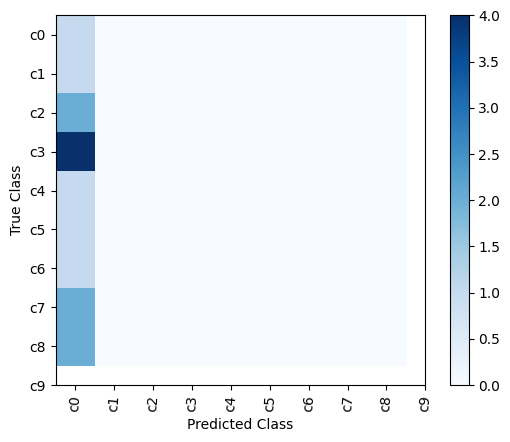

In [30]:
get_confusion_matrix(CNNmodel_a_005)

## Evaluating the models

In order to evaluate the performance of the model I build a function that return the prediction of the validation set that calculates : precision, recall and F1 scores for each class of images and the average for all classes, in combination with accuracy and loss this report gives us a complete overwie of the performance of each mdoel and the strenghts.

In [32]:
from sklearn.metrics import classification_report

def generate_validation_report(model, model_name):

    # Initialize empty arrays to accumulate predictions and true labels
    predictions = []
    true_labels = []

    # Iterate over all batches of validation data
    for i in range(len(validation_generator)):
        # Get the image and label arrays for the current batch
        x_val = validation_generator[i][0]
        y_val = validation_generator[i][1]

        # Use the model to predict the class probabilities for the current batch
        class_probabilities = model.predict(x_val, verbose=0)

        # The model returns a probability value for each class
        # The one with the highest probability is the predicted class for each instance
        batch_predictions = np.argmax(class_probabilities, axis=1)
        
        # The actual labels are one-hot encoded, so get the class index with the value 1 for each instance
        batch_true_labels = np.argmax(y_val, axis=1)

        # Accumulate the predictions and true labels for all instances in the current batch
        predictions.extend(batch_predictions)
        true_labels.extend(batch_true_labels)

    # Calculate the overall accuracy and loss
    accuracy = np.mean(np.array(predictions) == np.array(true_labels))
    loss = model.evaluate(validation_generator)[0]

    # Calculate the precision, recall, and other metrics for all batches
    classification_report_str = classification_report(true_labels, predictions)

    # Construct the final report with accuracy and loss
    final_report = f"Report for model {model_name}:\n{classification_report_str}\nAccuracy: {accuracy:.4f}\nLoss: {loss:.4f}"

    return final_report

In [33]:
reports = []

for model_name,model in trained_models.items():
    reports.append(generate_validation_report(model, model_name))


449/449 [==============================] - 23s 52ms/step - loss: 2.3010 - accuracy: 0.1110


c:\Users\lucac\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\lucac\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\lucac\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

In [36]:
# Code to print the performance of each model

from tabulate import tabulate


# Split each report into lines
report_lines = [report.split('\n') for report in reports]

# Determine the maximum number of lines among all reports
max_lines = max(len(lines) for lines in report_lines)

# Pad each report to have the same number of lines
padded_reports = [lines + [''] * (max_lines - len(lines)) for lines in report_lines]

# Transpose the padded reports to align the columns
transposed_reports = zip(*padded_reports)

# Convert the transposed reports to a list of lists
table_data = [list(lines) for lines in transposed_reports]

# Print the table
table = tabulate(table_data, headers=[''] + list(range(len(reports))), tablefmt='fancy_grid')
print(table)


╒═══════════════════════════════════════════════════════╤═══════════════════════════════════════════════════════╤═══════════════════════════════════════════════════════╤═══════════════════════════════════════════════════════╤═══════════════════════════════════════════════════════╤═══════════════════════════════════════════════════════╕
│                                                       │ 0                                                     │ 1                                                     │ 2                                                     │ 3                                                     │ 4                                                     │
╞═══════════════════════════════════════════════════════╪═══════════════════════════════════════════════════════╪═══════════════════════════════════════════════════════╪═══════════════════════════════════════════════════════╪═══════════════════════════════════════════════════════╪═══════════════════════════════════════════

As it is posbile to see from the result the best model is a CNN with a Conv2D and a MAxPooling layer, in previus tests I have tried adding more layers but they didn't imporve the model. From tests the biggest impact is given by changing the learning rate. In addition all models were run with a single epoch, it is possile to infer that this is the reuslt of the high number of images used to train the model

### Considerations


1. Mobile_net_model_001: This model performs best out of all the models. It has the highest accuracy of 0.9817, and the lowest loss of 0.1163. This means the model predicts most of the test data correctly and has a small number of errors. Its precision, recall and f1-score are also consistently high across all classes (avg 0.98), suggesting that it is robust and performs well regardless of the specific class.

2. CNNmodel_001: It has the second highest accuracy of 0.9817, and the lowest loss of 0.0767. While also having a F1, Recall and Precision of 0.98. This means the model predicts most of the test data correctly and has a small number of errors. Important to notice that F1, Recall and precision are not always consistent across all classes.

3. Mobile_net_v2_model_001: This model also performs well, but it has a slightly lower accuracy (0.9734) and higher loss (0.1556) compared to the Mobile_net_model_001. Its precision, recall and f1-score are quite high, but slightly lower than the Mobile_net_model_001 and CNNmodel_001.

4. vgg16_model: This model has a lower accuracy (0.9697) and a higher loss (0.1341) than the previus models. Its precision, recall and f1-score are slightly lower than those of the previous models, indicating that it is not as accurate in its predictions.

5. Mobile_net_model_01: This model has the same accuracy as Mobile_net_v2_model_001, but significantly higher loss (2.5114), indicating more errors in prediction. While its precision, recall and f1-score are quite high but very incosistent.

6. CNNmodel_a_005 model: This model performs very poorly compared to the others. It has very low accuracy (0.1110) and a very high loss (2.3010), indicating a high number of errors. Its precision, recall and f1-score are also very low, showing poor performance across all classes.

In the context of deploying any of these model the two possible choises are either Mobile_net_model_001 or CNNmodel_001, but given the higher consistency of F1, Recall precision of Mobile_net_model_001, its higher accuracy and lower training time 2.28 (minutes) vs 3.01 (minutes), Mobile_net_model_001 is the optimal choice.
